## <font color='darkblue'>Preface</font>
(go/mlclass-colab-representation) In this exercise, you'll experiment with different ways to represent features.

### <font color='darkgreen'>Learning Objectives:</font>

After doing this Colab, you'll know how to:

  * Use [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) methods to represent features in different ways.
  * Represent features as [bins](https://developers.google.com/machine-learning/glossary/#bucketing). 
  * Cross bins to create a [feature cross](https://developers.google.com/machine-learning/glossary/#feature_cross). 

### <font color='darkgreen'>Import relevant modules</font>

In [1]:
#!pip install pydot
#!pip install graphviz

In [2]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

tf.keras.backend.set_floatx('float32')
print("Imported the modules.")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Imported the modules.


<a id='sect0'></a>
### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>The Dataset</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Linear Regression Model</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Feature Engineering</a></b></font>

<a id='sect1'></a>
## <font color='darkblue'>The Dataset</font>
  
Like several of the previous Colabs, this exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

### <font color='darkgreen'>Load, scale, and shuffle the examples</font>

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

The code cell then scales the `median_house_value` to a more human-friendly range and then shuffles the examples.

In [3]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

### <font color='darkgreen'>Represent latitude and longitude as floating-point values</font>

<font size='3ptx'><b>Previous examples trained on only a single feature or a single synthetic feature. By contrast, this exercise trains on two features</b></font>. Furthermore, **this notebook introduces <a href='https://www.tensorflow.org/api_docs/python/tf/feature_column'><font color='darkblue'>feature columns</font></a>, which provide a sophisticated way to represent features**.

You create feature columns as possible:

  * Call a [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) method to represent a single feature, single feature cross, or single synthetic feature in the desired way.  For example, to represent a certain feature as floating-point values, call [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column). To represent a certain feature as a series of buckets or bins, call [`tf.feature_column.bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column).
  * Assemble the created representations into a Python list. 

<font size='3ptx'><b>A neighborhood's location is typically the most important feature in determining a house's value</b></font>. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location. 

The following code cell calls [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) twice, first to represent `latitude` as floating-point value and a second time to represent `longitude` as floating-point values. 

**This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented**. The transformations (<font color='brown'>collected in `fp_feature_layer`</font>) don't actually get applied until you pass a <b><a href='https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html'>DataFrame</a></b> to it, which will happen when we train the model. 

In [4]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

When used, the layer processes the raw inputs, according to the transformations described by the feature columns, and packs the result into a numeric array.  (<font color='brown'>The model will train on this numeric array.</font>) 

<a id='sect2'></a>
## <font color='darkblue'>Linear Regression Model</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect2_1'>Define functions that create and train a model, and a plotting function</a></b></font>
* <font size='3ptx'><b><a href='#sect2_2'>Train the model with floating-point representations</a></b></font>
* <font size='3ptx'><b><a href='#sect2_3'>Task 1: Why aren't floating-point values a good way to represent latitude and longitude?</a></b></font>

<a id='sect2_1'></a>
### <font color='darkgreen'>Define functions that create and train a model, and a plotting function</font>
The following code defines three functions:

  * `create_model`, which tells TensorFlow to build a linear regression model and to use the `feature_layer_as_fp` as the representation of the model's features.
  * `train_model`, which will ultimately train the model from training set examples.
  * `plot_the_loss_curve`, which generates a loss curve.

In [5]:
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name='median_house_value', verbose=0):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(
    x=features, y=label, batch_size=batch_size,
    epochs=epochs, shuffle=True, verbose=verbose)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse   


def plot_the_loss_curve(epochs, rmse, width=8, height=4):
  """Plot a curve of loss vs. epoch."""
  plt.rcParams['figure.figsize'] = [width, height]
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


<a id='sect2_2'></a>
### <font color='darkgreen'>Train the model with floating-point representations</font>
The following code cell calls the functions you just created to train, plot, and evaluate a model.

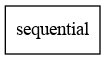

In [6]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)
tf.keras.utils.plot_model(my_model)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


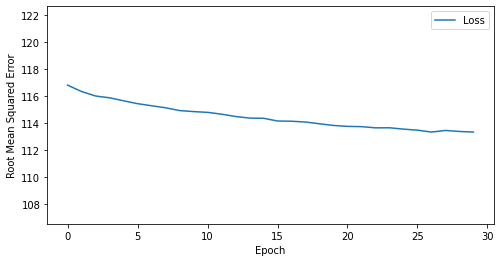

In [7]:
# Train the model on the training set.
epoch_data, rmse = train_model(my_model, train_df, epochs, batch_size)

plot_the_loss_curve(epoch_data, rmse)

In [8]:
print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
test_features


: Evaluate the new model against the test set:


{'longitude': array([-122.05, -118.3 , -117.81, ..., -119.7 , -117.12, -119.63]),
 'latitude': array([37.37, 34.26, 33.78, ..., 36.3 , 34.1 , 34.42]),
 'housing_median_age': array([27., 43., 27., ..., 10., 40., 42.]),
 'total_rooms': array([3885., 1510., 3589., ...,  956.,   96., 1765.]),
 'total_bedrooms': array([661., 310., 507., ..., 201.,  14., 263.]),
 'population': array([1537.,  809., 1484., ...,  693.,   46.,  753.]),
 'households': array([606., 277., 495., ..., 220.,  14., 260.]),
 'median_income': array([6.6085, 3.599 , 5.7934, ..., 2.2895, 3.2708, 8.5608])}

In [9]:
loss, metrics = my_model.evaluate(
  x=test_features, y=test_label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 629us/step - loss: 12206.0322 - root_mean_squared_error: 110.4809


In [10]:
print(f'loss={loss}; RMSE={metrics}')

loss=12206.0322265625; RMSE=110.48091125488281


<a id='sect2_3'></a>
### <font color='darkgreen'>Task 1: Why aren't floating-point values a good way to represent latitude and longitude?</font>
Are floating-point values a good way to represent `latitude` and `longitude`?

First question:

> No. Representing latitude and longitude as 
> floating-point values does not have much 
> predictive power. For example, neighborhoods at 
> latitude 35 are not 36/35 more valuable 
> (or 35/36 less valuable) than houses at 
> latitude 36.

Second question

> Representing `latitude` and `longitude` as 
> floating-point values provides almost no 
> predictive power. We're only using the raw values 
> to establish a baseline for future experiments 
> with better representations.

<a id='sect3'></a>
## <font color='darkblue'>Feature Engineering</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect3_1'>Represent latitude and longitude in buckets</a></b></font>
* <font size='3ptx'><b><a href='#sect3_2'>Train the model with bucket representations</a></b></font>
* <font size='3ptx'><b><a href='#sect3_3'>Task 2: Did buckets outperform floating-point representations?</a></b></font>
* <font size='3ptx'><b><a href='#sect3_4'>Task 3: What is a better way to represent location?</a></b></font>
* <font size='3ptx'><b><a href='#sect3_5'>Represent location as a feature cross</a></b></font>
* <font size='3ptx'><b><a href='#sect3_6'>Task 4: Did the feature cross outperform buckets?</a></b></font>
* <font size='3ptx'><b><a href='#sect3_7'>Task 5: Adjust the resolution of the feature cross</a></b></font>

<a id='sect3_1'></a>
### <font color='darkgreen'>Represent latitude and longitude in buckets</font>
<font size='3ptx'><b>The following code cell represents latitude and longitude in buckets (bins)</b></font>. Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets. 

**The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin", a different weight for neighborhoods in the "36" bin, and so on**. This representation will create approximately 20 buckets:
 
  * 10 buckets for `latitude`. 
  * 10 buckets for `longitude`. 

In [11]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns)

<a id='sect3_2'></a>
### <font color='darkgreen'>Train the model with bucket representations</font>
Run the following code cell to train the model with bucket representations rather than floating-point representations:

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


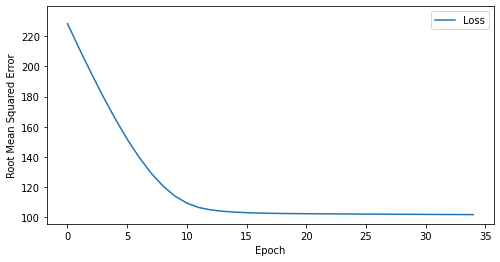

In [12]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

In [13]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
print("\n: Evaluate the new model against the test set:")
loss, metrics = my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)
print(f'loss={loss}; RMSE={metrics}')


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 917us/step - loss: 10197.4551 - root_mean_squared_error: 100.9825
loss=10197.455078125; RMSE=100.98245239257812


<a id='sect3_3'></a>
### <font color='darkgreen'>Task 2: Did buckets outperform floating-point representations?</font>
Compare the model's `root_mean_squared_error` values for the two representations (floating-point vs. buckets)?  Which model produced lower losses? 

> Bucket representation outperformed 
> floating-point representations.  
> However, you can still do far better.

<a id='sect3_4'></a>
### <font color='darkgreen'>Task 3: What is a better way to represent location?</font>
Buckets are a big improvement over floating-point values. Can you identify an even better way to identify location with `latitude` and `longitude`?

> **Representing location as a feature cross should 
> produce better results.**
>
> In Task 2, you represented latitude in 
> one-dimensional buckets and longitude in 
> another series of one-dimensional buckets. 
> Real-world locations, however, exist in 
> two dimension. Therefore, you should
> represent location as a two-dimensional feature
> cross. That is, you'll cross the 10 or so latitude 
> buckets with the 10 or so longitude buckets to 
> create a grid of 100 cells. 
>
> The model will learn separate weights for each 
> of the cells.

<a id='sect3_5'></a>
### <font color='darkgreen'>Represent location as a feature cross</font>

The following code cell represents location as a feature cross. That is, the following code cell first creates buckets and then calls [`tf.feature_column.crossed_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) to cross the buckets.

In [14]:
def generate_feature_cross_layer(resolution_in_degrees = 1.0): 
  # Create a new empty list that will eventually hold the generated feature column.
  feature_columns = []
  
  # Create a bucket feature column for latitude.
  latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
  latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
  latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

  # Create a bucket feature column for longitude.
  longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
  longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
  longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

  # Create a feature cross of latitude and longitude.
  latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
  crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
  feature_columns.append(crossed_feature)

  # Convert the list of feature columns into a layer that will later be fed into
  # the model. 
  feature_cross_feature_layer = layers.DenseFeatures(feature_columns)
  return feature_cross_feature_layer

Invoke the following code cell to test your solution for Task 3. Please ignore the warning messages.

In [15]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, generate_feature_cross_layer())

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


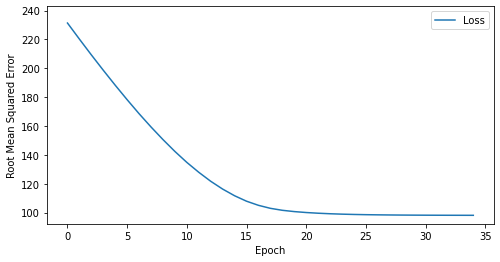

In [16]:
plot_the_loss_curve(epochs, rmse)

In [17]:
print("\n: Evaluate the new model against the test set:")
loss, metrics = my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)
print(f'loss={loss}; RMSE={metrics}')


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 698us/step - loss: 9519.9863 - root_mean_squared_error: 97.5704
loss=9519.986328125; RMSE=97.57041931152344


<a id='sect3_6'></a>
### <font color='darkgreen'>Task 4: Did the feature cross outperform buckets?</font>

Compare the model's `root_mean_squared_error` values for the two representations (buckets vs. feature cross)?  Which model produced lower losses? 
> Yes, representing these features as a feature 
> cross produced much lower loss values than 
> representing these features as buckets

<a id='sect3_7'></a>
### <font color='darkgreen'>Task 5: Adjust the resolution of the feature cross</font>

Return to the code cell in the "Represent location as a feature cross" section. Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood. 

Experiment with `resolution_in_degrees` to answer the following questions:

  1. What value of `resolution_in_degrees` produces the best results (lowest loss value)?

> 1. A resolution of ~0.4 degree provides the best results.
  
  2. Why does loss increase when the value of `resolution_in_degrees` drops below a certain value?

> Below ~0.4 degree, loss increases because the 
>   dataset does not contain enough examples in 
>   each cell to accurately predict prices for 
>   those cells.

Finally, answer the following question:

  3. What feature (that does not exist in the California Housing Dataset) would
     be a better proxy for location than latitude X longitude.
     
> Postal code would be a far better feature 
>   than latitude X longitude, assuming that 
>   the dataset contained sufficient examples 
>   in each postal code.

In [18]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, generate_feature_cross_layer(0.4))

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


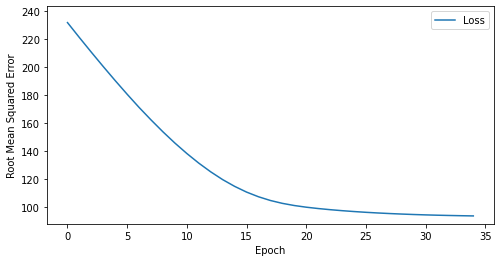

In [19]:
plot_the_loss_curve(epochs, rmse)

In [20]:
print("\n: Evaluate the new model against the test set:")
loss, metrics = my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)
print(f'loss={loss}; RMSE={metrics}')


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 1ms/step - loss: 8643.8330 - root_mean_squared_error: 92.9722
loss=8643.8330078125; RMSE=92.97221374511719
